C:\Users\35406\AppData\Local\Temp\ipykernel_33420\3344819898.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


elephants


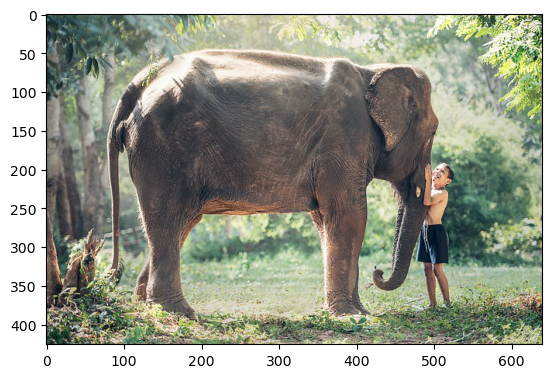

In [2]:
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# 更新标签和类别字典
label_dict = {"horses": 0, "elephants": 1, "butterflies": 2}
class_dict = {0: "horses", 1: "elephants", 2: "butterflies"}
N = 3  # 更新类别数量

class MyDataset(Dataset):
    def __init__(self, _data_dir, _transform, _loader):
        self.labels = [_label for _label in os.listdir(_data_dir)]
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label)
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list]
        self.transform = _transform

    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label

    def __len__(self):
        return len(self.data)

def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "data/training_data/"  # 确保这个路径包含新的类别
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader

# 其余代码保持不变...

class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)  # 如果需要，可以调整这里的层
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.out = nn.Linear(10, N)  # 更新输出层

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x

# 其余代码保持不变...

import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn
from classify.cnn import cnn
from classify.data_process import class_dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义模型
model = cnn().to(device)
# 加载模型权重
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

# 更新测试图像路径
_img_path = "data/testing_data/elephants/e83db30d2cfd033ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.jpg"

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

# 使用模型进行预测
output = model(img_transform)

# 获取预测结果
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

# 显示图像
img = Image.open(_img_path)
plt.imshow(img)
plt.show()

In [7]:
train()

data processing...
train...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  3%|##7                                                                                | 1/30 [00:05<02:26,  5.07s/it]

Epoch 000 train_loss 0.69041 val_loss 0.71283


  7%|#####5                                                                             | 2/30 [00:10<02:20,  5.02s/it]

Epoch 001 train_loss 0.66148 val_loss 0.73221


 10%|########3                                                                          | 3/30 [00:15<02:14,  5.00s/it]

Epoch 002 train_loss 0.63053 val_loss 0.74118


 13%|###########                                                                        | 4/30 [00:19<02:09,  4.97s/it]

Epoch 003 train_loss 0.60586 val_loss 0.59955


 17%|#############8                                                                     | 5/30 [00:25<02:05,  5.00s/it]

Epoch 004 train_loss 0.58516 val_loss 0.59193


 20%|################6                                                                  | 6/30 [00:30<02:01,  5.05s/it]

Epoch 005 train_loss 0.56396 val_loss 0.61281


 23%|###################3                                                               | 7/30 [00:35<01:57,  5.12s/it]

Epoch 006 train_loss 0.53831 val_loss 0.56035


 27%|######################1                                                            | 8/30 [00:40<01:51,  5.09s/it]

Epoch 007 train_loss 0.53220 val_loss 0.58576


 30%|########################9                                                          | 9/30 [00:45<01:45,  5.04s/it]

Epoch 008 train_loss 0.51465 val_loss 0.59177


 33%|###########################3                                                      | 10/30 [00:50<01:39,  4.98s/it]

Epoch 009 train_loss 0.51262 val_loss 0.56475


 37%|##############################                                                    | 11/30 [00:55<01:34,  4.98s/it]

Epoch 010 train_loss 0.50500 val_loss 0.64652


 40%|################################8                                                 | 12/30 [01:00<01:30,  5.00s/it]

Epoch 011 train_loss 0.49751 val_loss 0.58299


 43%|###################################5                                              | 13/30 [01:05<01:25,  5.01s/it]

Epoch 012 train_loss 0.49327 val_loss 0.59778


 47%|######################################2                                           | 14/30 [01:10<01:20,  5.01s/it]

Epoch 013 train_loss 0.47771 val_loss 0.56692


 50%|#########################################                                         | 15/30 [01:15<01:14,  4.97s/it]

Epoch 014 train_loss 0.46802 val_loss 0.55517


 53%|###########################################7                                      | 16/30 [01:20<01:09,  4.97s/it]

Epoch 015 train_loss 0.47614 val_loss 0.66633


 57%|##############################################4                                   | 17/30 [01:25<01:05,  5.01s/it]

Epoch 016 train_loss 0.45777 val_loss 0.63282


 60%|#################################################1                                | 18/30 [01:30<01:00,  5.02s/it]

Epoch 017 train_loss 0.44926 val_loss 0.49766


 63%|###################################################9                              | 19/30 [01:35<00:55,  5.03s/it]

Epoch 018 train_loss 0.43818 val_loss 0.60943


 67%|######################################################6                           | 20/30 [01:40<00:49,  4.99s/it]

Epoch 019 train_loss 0.43715 val_loss 0.53149


 70%|#########################################################4                        | 21/30 [01:45<00:45,  5.01s/it]

Epoch 020 train_loss 0.42777 val_loss 0.54367


 73%|############################################################1                     | 22/30 [01:50<00:40,  5.02s/it]

Epoch 021 train_loss 0.42167 val_loss 0.53923


 77%|##############################################################8                   | 23/30 [01:55<00:35,  5.02s/it]

Epoch 022 train_loss 0.41583 val_loss 0.52610


 80%|#################################################################6                | 24/30 [02:00<00:30,  5.06s/it]

Epoch 023 train_loss 0.41593 val_loss 0.53730


 83%|####################################################################3             | 25/30 [02:05<00:25,  5.05s/it]

Epoch 024 train_loss 0.39452 val_loss 0.57724


 87%|#######################################################################           | 26/30 [02:10<00:20,  5.09s/it]

Epoch 025 train_loss 0.40114 val_loss 0.55945


 90%|#########################################################################8        | 27/30 [02:15<00:15,  5.07s/it]

Epoch 026 train_loss 0.40143 val_loss 0.56093


 93%|############################################################################5     | 28/30 [02:20<00:10,  5.09s/it]

Epoch 027 train_loss 0.39803 val_loss 0.56150


 97%|###############################################################################2  | 29/30 [02:26<00:05,  5.11s/it]

Epoch 028 train_loss 0.40357 val_loss 0.56026


100%|##################################################################################| 30/30 [02:30<00:00,  5.03s/it]
2024-11-20 15:27:51.519 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 154.42955422401428 s


Epoch 029 train_loss 0.39236 val_loss 0.52163


In [8]:
nn.Softmax

torch.nn.modules.activation.Softmax

In [9]:
test()

data processing...


C:\Users\admin\AppData\Local\Temp/ipykernel_14416/1345067293.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


Accuracy:85%


In [10]:
import unittest
from PIL import Image

import torch
from matplotlib import pyplot as plt
from torchvision import transforms

from classify.cnn import cnn
from classify.data_process import class_dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = "data/testing_data/dogs/dog.1031.jpg"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)

output

C:\Users\admin\AppData\Local\Temp/ipykernel_14416/3000547427.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


tensor([[-1.0073, -0.4544]], grad_fn=<LogSoftmaxBackward0>)

In [11]:
np.log(0.5)

-0.6931471805599453

In [12]:
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

dogs


In [2]:
import torch
torch.__version__

'2.5.1+cpu'